In [50]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, compression='zip', index_col=0)
    df = reduce_mem_usage(df)
    return df

In [7]:
def lgbm(X_train, y_train, X_val, y_val, X_test):
    kf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train, y=y_train)
    
    param_grid = {
        'learning_rate': [0.05],
        'reg_alpha': [0.01, 0.05],
        'max_depth': [5, 7],
        } 
    
    callbacks = [lgb.early_stopping(stopping_rounds=100)]
    lgb_estimator = lgb.LGBMClassifier(objective='binary', n_estimators=100, num_leaves=31, metric='auc', verbosity=-1)
    
    gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=kf)
    lgb_model = gsearch.fit(X=X_train, y=y_train)
    print(lgb_model.best_params_, lgb_model.best_score_)
    
    lgb_estimator = lgb.LGBMClassifier(objective='binary', n_estimators=100, metric='auc', verbosity=-1, **lgb_model.best_params_)
    lgb_estimator.fit(X=X_train, y=y_train, eval_set=(X_val, y_val), callbacks=callbacks)
    # y_train_pred = lgb_estimator.predict(X=X_train, num_iteration=lgb_estimator.best_iteration_)
    y_train_pred_proba = lgb_estimator.predict_proba(X_train, num_iteration=lgb_estimator.best_iteration_)[:, 1]
    y_pred_proba = lgb_estimator.predict_proba(X_test, num_iteration=lgb_estimator.best_iteration_)[:, 1]
    
    importance_df = pd.DataFrame()
    importance_df["feature"] = X_train.columns.tolist()
    importance_df["importance"] = lgb_estimator.feature_importances_
    
    # pred_auc = roc_auc_score(y_test, y_pred_proba)
    # print('Predicting AUC score {:.6f}'.format(pred_auc))
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    print('Training AUC score {:.6f}'.format(train_auc))

    return y_pred_proba, importance_df

In [53]:
def logistic(X_train, y_train, X_val, y_val, X_test):
    clf = LogisticRegressionCV(cv=10, max_iter=200, random_state=42).fit(X_train, y_train)
    # y_pred = clf.predict(X_test)
    y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
    y_val_pred_proba = clf.predict_proba(X_val)[:, 1]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    # pred_auc = roc_auc_score(y_test, y_pred_proba)
    # print('Predicting AUC score {:.6f}'.format(pred_auc))
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    print('Training AUC score {:.6f}'.format(train_auc))
    val_auc = roc_auc_score(y_val, y_val_pred_proba)
    print('Validating AUC score {:.6f}'.format(val_auc))
    
    return y_pred_proba

In [54]:
def rf(X_train, y_train, X_val, y_val, X_test):
    kf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train, y=y_train)
    
    param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'min_samples_leaf': [1, 2, 5],
        'max_depth': [5, 7]
        }
    
    params = {
        'criterion': 'gini',
        'min_samples_leaf': 1,
        'max_depth': 5
    }
    
    # rf_estimator = RandomForestClassifier(n_estimators=100)
    
    # gsearch = GridSearchCV(estimator=rf_estimator, param_grid=param_grid, cv=kf)
    # rf_model = gsearch.fit(X=X_train, y=y_train)
    # print(rf_model.best_params_, rf_model.best_score_)
    
    rf_estimator = RandomForestClassifier(n_estimators=100, **params)#rf_model.best_params_
    rf_estimator.fit(X=X_train, y=y_train)
    # y_train_pred = lgb_estimator.predict(X=X_train, num_iteration=lgb_estimator.best_iteration_)
    # y_pred = rf_estimator.predict(X=X_test, num_iteration=rf_estimator.best_iteration_)
    y_train_pred_proba = rf_estimator.predict_proba(X_train)[:, 1]
    y_val_pred_proba = rf_estimator.predict_proba(X_val)[:, 1]
    y_pred_proba = rf_estimator.predict_proba(X_test)[:, 1]
    
    importance_df = pd.DataFrame()
    importance_df["feature"] = X_train.columns.tolist()
    importance_df["importance"] = rf_estimator.feature_importances_
    
    # pred_auc = roc_auc_score(y_test, y_pred_proba)
    # print('Predicting AUC score {:.6f}'.format(pred_auc))
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    print('Training AUC score {:.6f}'.format(train_auc))
    val_auc = roc_auc_score(y_val, y_val_pred_proba)
    print('Validating AUC score {:.6f}'.format(val_auc))

    return y_pred_proba, importance_df

In [10]:
application_train = import_data('features_train.csv')
application_test = import_data('features_test.csv')
application_test = application_test.drop('TARGET', axis=1)
print(application_train.shape)
print(application_test.shape)
print(application_train.head())
print(application_test.head())

Memory usage of dataframe is 1839.36 MB
Memory usage after optimization is: 663.07 MB
Decreased by 64.0%
Memory usage of dataframe is 291.56 MB
Memory usage after optimization is: 99.81 MB
Decreased by 65.8%
(307511, 783)
(48744, 782)
   SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002     1.0                   0            0             0   
1      100003     0.0                   0            1             0   
2      100004     0.0                   1            0             1   
3      100006     0.0                   0            1             0   
4      100007     0.0                   0            0             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0             0          202500.0    406597.5      24700.5   
1                1             0          270000.0   1293502.5      35698.5   
2                0             0           67500.0    135000.0       6750.0   
3               

In [11]:
application_train['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
application_test['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
FLAG_DOCUMENT = [
    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
application_train['FLAG_DOCUMENT'] = application_train[FLAG_DOCUMENT].sum(axis=1)
application_test['FLAG_DOCUMENT'] = application_test[FLAG_DOCUMENT].sum(axis=1)
application_train.drop(FLAG_DOCUMENT, axis=1, inplace=True)
application_test.drop(FLAG_DOCUMENT, axis=1, inplace=True)
# Age Feature
application_train['AGE'] = application_train['DAYS_BIRTH'] / (-365)
application_test['AGE'] = application_test['DAYS_BIRTH'] / (-365)
# MEAN_EXT_SOURCE
application_train['MEAN_EXT_SOURCE'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
application_test['MEAN_EXT_SOURCE'] = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# Generate YEARS_EMPLOYED
application_train['YEARS_EMPLOYED'] = application_train['DAYS_EMPLOYED'] / (-365)
application_test['YEARS_EMPLOYED'] = application_test['DAYS_EMPLOYED'] / (-365)
# DAYS_BIRTH_SQUARED
application_train['DAYS_BIRTH_SQUARED'] = application_train['DAYS_BIRTH'] ** 2
application_test['DAYS_BIRTH_SQUARED'] = application_test['DAYS_BIRTH'] ** 2
# Generate DEBT_TO_INCOME_RATIO 
application_train['DEBT_TO_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
application_test['DEBT_TO_INCOME_RATIO'] = application_test['AMT_CREDIT'] / application_test['AMT_INCOME_TOTAL']
# Generate INCOME_TO_CREDIT 
application_train['INCOME_TO_CREDIT'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']
application_test['INCOME_TO_CREDIT'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_CREDIT']
application_train['_INCOME_CLASS'] = pd.qcut(application_train['AMT_INCOME_TOTAL'], 3,
                                             labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_train['ANNUITY_CLASS'] = pd.qcut(application_train['AMT_ANNUITY'], 3,
                                             labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
# application_train['AMT_GOODS_PRICE_0.2_0.7']=np.where((application_train['AMT_GOODS_PRICE']<= 70000) & (application_train['AMT_GOODS_PRICE']>=20000) ,1,0)
application_train['DAYS_BIRTH_CLASS'] = np.where(application_train['DAYS_BIRTH'] < -15000, 1, 0)
application_train['CREDIT_UNDER_100K'] = np.where(application_train['AMT_CREDIT'] < 100000, 1, 0)
application_train['YEARS_EMPLOYED_CLASS'] = np.where(application_train['DAYS_EMPLOYED'] < 100000, 1, 0)

application_test['_INCOME_CLASS'] = pd.qcut(application_test['AMT_INCOME_TOTAL'], 3,
                                            labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_test['ANNUITY_CLASS'] = pd.qcut(application_test['AMT_ANNUITY'], 3,
                                            labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
# application_test['AMT_GOODS_PRICE_0.2_0.7']=np.where((application_test['AMT_GOODS_PRICE']<= 7000) & (application_test['AMT_GOODS_PRICE']>=2000) ,1,0)
application_test['DAYS_BIRTH_CLASS'] = np.where(application_test['DAYS_BIRTH'] < -15000, 1, 0)
application_test['CREDIT_UNDER_100K'] = np.where(application_test['AMT_CREDIT'] < 100000, 1, 0)
application_test['YEARS_EMPLOYED_CLASS'] = np.where(application_test['DAYS_EMPLOYED'] < 100000, 1, 0)
AMT_REQ_CREDIT = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                  'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT']
application_train.drop(AMT_REQ_CREDIT, axis=1, inplace=True)
application_test.drop(AMT_REQ_CREDIT, axis=1, inplace=True)
SK_ID_CURR = application_test["SK_ID_CURR"]
application_test.drop('SK_ID_CURR', inplace=True, axis=1)
SK_ID_CURR_TRAIN = application_train["SK_ID_CURR"]
application_train.drop('SK_ID_CURR', inplace=True, axis=1)
# Detect highly missing numeric features 
application_train_numeric = application_train.select_dtypes(include=['number'])
missings = application_train_numeric.loc[:, application_train_numeric.isna().mean() >= 0.6]
highly_missing_features = missings.columns
print("missing columns: ", missings.columns)
#Remove highly missing features
application_train.drop(highly_missing_features, axis=1, inplace=True)
application_test.drop(highly_missing_features, axis=1, inplace=True)
target = application_train['TARGET']
features_train = application_train.drop('TARGET', axis=1)

numeric_imputer = SimpleImputer(strategy='median')

numeric_features_train = features_train.select_dtypes(include='number')
numeric_features_test = application_test.select_dtypes(include='number')

numeric_features_train.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_features_test.replace([np.inf, -np.inf], np.nan, inplace=True)

imputed_numeric_features_train = numeric_imputer.fit_transform(numeric_features_train)
imputed_numeric_features_test = numeric_imputer.transform(numeric_features_test)
categorical_features_train = features_train.select_dtypes(include='object')
# using dummy_na=False ,we perform onehot encoding without affecting data distribution
dummy_categorical_features_train = pd.get_dummies(categorical_features_train, dummy_na=False)

# Concatenate imputed numerical and categorical features Train
imputed_features_train = pd.concat(
    [pd.DataFrame(imputed_numeric_features_train, columns=numeric_features_train.columns),
     dummy_categorical_features_train], axis=1)

# Impute categorical features Test using mode imputation and one-hot encoding
categorical_features_test = application_test.select_dtypes(include='object')
dummy_categorical_features_test = pd.get_dummies(categorical_features_test, dummy_na=False)
missing_columns = set(dummy_categorical_features_train.columns) - set(
    dummy_categorical_features_test.columns.get_level_values(0))
for col in missing_columns:
    dummy_categorical_features_test[col] = 0
dummy_categorical_features_test = dummy_categorical_features_test[dummy_categorical_features_train.columns]

# Concatenate imputed numerical and categorical features
imputed_features_test = pd.concat(
    [pd.DataFrame(imputed_numeric_features_test, columns=numeric_features_test.columns),
    dummy_categorical_features_test], axis=1)

C:\Users\22765\AppData\Local\Temp\ipykernel_20572\1921938411.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_train['FLAG_DOCUMENT'] = application_train[FLAG_DOCUMENT].sum(axis=1)
C:\Users\22765\AppData\Local\Temp\ipykernel_20572\1921938411.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_test['FLAG_DOCUMENT'] = application_test[FLAG_DOCUMENT].sum(axis=1)
C:\Users\22765\AppData\Local\Temp\ipykernel_20572\1921938411.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

missing columns:  Index(['OWN_CAR_AGE', 'YEARS_BUILD_MODE', 'FLOORSMIN_MODE',
       'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'COMMONAREA_MEDI',
       'NEW_SOURCES_PROD', 'NEW_CAR_TO_BIRTH_RATIO', 'NEW_CAR_TO_EMPLOY_RATIO',
       'prev_avg_RATE_INTEREST_PRIMARY',
       ...
       'inst_DAYS_LAST_UNDERPAID', 'cc_score', 'bubl_score', 'Total_AMT_LEFT',
       'Total_AMT_LEFT_INCOME_RATIO', 'AMT_ANNUITY_to_prev_refused',
       'AMT_CREDIT_to_prev_refused', 'AMT_PAY_YEAR_to_prev_refused',
       'AMT_DIFF_CREDIT_GOODS_to_prev_refused',
       'AMT_CREDIT_GOODS_PERC_to_prev_refused'],
      dtype='object', length=301)


In [18]:
X = imputed_features_train.copy()
print(X.dtypes)
y = target

X.fillna(-9999, inplace=True)
y.fillna(-9999, inplace=True)
print(X.columns[X.columns.str.contains(',|[|]|{|}|"|:')])
new_col_names = X.columns.str.replace(',', ' ')
new_col_names = new_col_names.str.replace(':', ' ')
X.columns = new_col_names

#splitting data to train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1, random_state=27)
X_test = imputed_features_test.fillna(-9999)
X_test.columns = new_col_names

NAME_CONTRACT_TYPE                                                                float64
CODE_GENDER                                                                       float64
FLAG_OWN_CAR                                                                      float64
FLAG_OWN_REALTY                                                                   float64
CNT_CHILDREN                                                                      float64
                                                                                   ...   
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Loan for working capital replenishment       bool
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Microloan                                    bool
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Mortgage                                     bool
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Real estate loan                             bool
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Unknown type of loan                         bool
Length: 60

In [14]:
lgbm_pred, lgbm_importance = lgbm(X_train, y_train, X_val, y_val, X_test)

{'learning_rate': 0.05, 'max_depth': 7, 'reg_alpha': 0.01} 0.9202193969814141
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.791541
Training AUC score 0.812219


In [15]:
print(lgbm_pred)

[0.02736681 0.17262121 0.04446821 ... 0.01848086 0.03793892 0.10448097]


In [32]:
lgbm_top_f = lgbm_importance.sort_values(by='importance', ascending=False).head(10)
lgbm_top_f

,feature,importance
420,buro_score_sum,132
60,NEW_EXT_SOURCES_MEAN,123
416,prev_score_mean,113
65,AMT_PAY_YEAR,98
68,AMT_DIFF_CREDIT_GOODS,91
421,buro_score_mean,89
33,EXT_SOURCE_1,73
34,EXT_SOURCE_2,72
1,CODE_GENDER,67
443,MEAN_EXT_SOURCE,59


<BarContainer object of 10 artists>

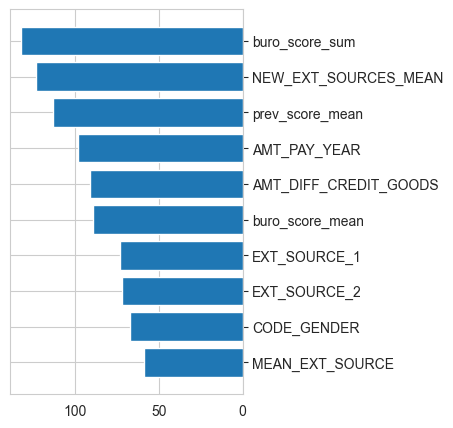

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3,5))
lgbm_top_f = lgbm_top_f.sort_values(by='importance', ascending=True)
ax = plt.gca()
ax.yaxis.set_ticks_position('right')
ax.invert_xaxis()
plt.barh(lgbm_top_f['feature'], lgbm_top_f['importance'])

In [16]:
lgbm_pred_df = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'TARGET': lgbm_pred})
lgbm_pred_df.to_csv('lgb_pred.csv')

In [55]:
logistic_pred = logistic(X_train, y_train, X_val, y_val, X_test)

Training AUC score 0.571296
Validating AUC score 0.576822


In [56]:
print(logistic_pred)
logistic_pred_df = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'TARGET': logistic_pred})
logistic_pred_df.to_csv('logistic_pred.csv')

[0.18323557 0.2512998  0.10472482 ... 0.08038407 0.09160815 0.04398251]


In [57]:
rf_pred, rf_importance = rf(X_train, y_train, X_val, y_val, X_test)

Training AUC score 0.769659
Validating AUC score 0.769902


In [26]:
print(rf_pred)
rf_pred_df = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'TARGET': rf_pred})
rf_pred_df.to_csv('rf_pred.csv')

In [42]:
print(rf_importance.sort_values(by='importance', ascending=False).head(10))

                     feature  importance
60      NEW_EXT_SOURCES_MEAN    0.132795
443          MEAN_EXT_SOURCE    0.087893
417           prev_score_max    0.061307
34              EXT_SOURCE_2    0.060045
416          prev_score_mean    0.059414
421          buro_score_mean    0.050283
420           buro_score_sum    0.043398
35              EXT_SOURCE_3    0.043065
424  buro_score_recent2y_sum    0.042673
425          buro_score_last    0.034622


<BarContainer object of 10 artists>

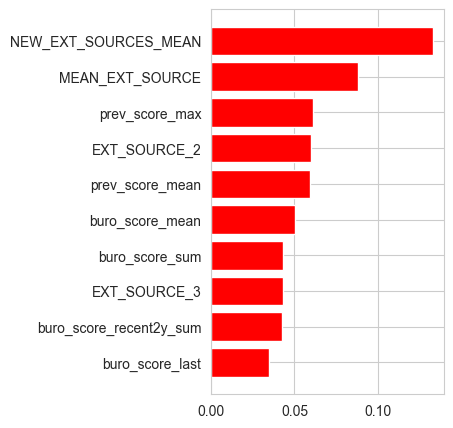

In [47]:
rf_top_f = rf_importance.sort_values(by='importance', ascending=False).head(10)
rf_top_f = rf_top_f.sort_values(by='importance', ascending=True)
plt.figure(figsize=(3, 5))
plt.barh(rf_top_f['feature'], rf_top_f['importance'], color='r')

In [59]:
print(set(rf_top_f['feature']) & set(lgbm_top_f['feature']))

{'NEW_EXT_SOURCES_MEAN', 'buro_score_mean', 'prev_score_mean', 'EXT_SOURCE_2', 'buro_score_sum', 'MEAN_EXT_SOURCE'}
